In [250]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os
import json
import xmltodict
import pandas as pd
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter1d
import pyedflib

os.chdir("..")
from config import Config
from utils.util_json import NumpyEncoder
from utils.get_h5_data import get_h5_data, get_h5_interp, get_h5_am

In [548]:
# Set up config
config = Config()
# Choose ru4
m_run = '5'

# Edit config
config.model_dir = os.path.join(config.data_dir, 'model' + '_' + m_run)
config.model_F_path = os.path.join(config.model_dir, 'modelF')
config.model_L_path = os.path.join(config.model_dir, 'modelL')
config.save_dir = config.model_dir
if m_run == 'eeg5':
    config.only_eeg = 1
    config.n_channels = 2
    channel_idx = [0, 1]
elif m_run == 'eegeogemg5':
    config.only_eeg = 2
    config.n_channels = 5
    channel_idx = [0, 1, 2, 3, 5]
elif m_run == 'ecg5':
    config.only_eeg = 3
    config.n_channels = 1
    channel_idx = [4]
elif m_run == 'resp5':
    config.only_eeg = 4
    config.n_channels = 5
    channel_idx = [7, 8, 9, 10, 11]
elif m_run == 'com5':
    config.only_eeg = 5
    config.n_channels = 11
    channel_idx = [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11]
elif m_run == '5':
    config.only_eeg = 0
    config.n_channels = 12
    channel_idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
config.interp_dir = os.path.join(config.model_dir, 'interpretation')

In [549]:
# Select filename
# ECG
#record = 'cfs-visit5-800914.hdf5'
# EEG, EEG+EOG+EMG, full
record = 'cfs-visit5-800105.hdf5'
# resp
#record = 'cfs-visit5-800820.hdf5'
#record = 'cfs-visit5-800048.hdf5'
#record = 'shhs1-201516.hdf5'
#record = 'cfs-visit5-802144.hdf5' # Old
#record = 'cfs-visit5-802128.hdf5' # Young
record_path = os.path.join(config.pretrain_dir, record)
print(record_path)

H:\nAge\all\cfs-visit5-800105.hdf5


In [550]:
# Export all pre-predictions
export_all = False
if export_all:
    with open(os.path.join(config.model_dir, 'predictions_pre.json'), 'r') as fp:
        predictions_pre = json.load(fp)
        for r in predictions_pre.keys():
            unpackaged_path = os.path.join(config.model_dir, 'predictions_pre_sep', r[:-5] + '.json')
            if not os.path.exists(unpackaged_path):
                pred_pre_record = {r: predictions_pre[r]}
                with open(unpackaged_path, 'w') as fp:
                    json.dump(pred_pre_record, fp, sort_keys=True, indent=4, cls=NumpyEncoder)

In [551]:
# Load predictions
# Full model
with open(os.path.join(config.model_dir, 'predictions.json'), 'r') as fp:
    predictions = json.load(fp)

if m_run != 'com5':
    unpackaged_path = os.path.join(config.model_dir, 'predictions_pre_sep', record[:-5] + '.json')
    if os.path.exists(unpackaged_path):
        with open(unpackaged_path, 'r') as fp:
            predictions_pre = json.load(fp)
    else:
        with open(os.path.join(config.model_dir, 'predictions_pre.json'), 'r') as fp:
            predictions_pre = json.load(fp)
            # Clear all other record data
            pred_record = predictions[record]
            pred_pre_reocrd = predictions_pre[record]
            predictions.clear()
            predictions_pre.clear()
            predictions[record] = pred_record
            predictions_pre[record] = pred_pre_reocrd
            print(unpackaged_path)
            with open(unpackaged_path, 'w') as fp:
                json.dump(predictions_pre, fp, sort_keys=True, indent=4, cls=NumpyEncoder)


In [552]:
# Read sleep stages
path_ssc = 'G:\\cfs\\polysomnography\\annotations-events-profusion'
#path_ssc = 'H:\\shhs\\polysomnography\\annotations-events-profusion\\shhs1'
path_ssc_file = os.path.join(path_ssc, record[:-5] + '-profusion.xml')
with open(path_ssc_file) as f_xml:
    ssc_dict=xmltodict.parse(f_xml.read())
ssc = [int(x) for x in ssc_dict['CMPStudyConfig']['SleepStages']['SleepStage']]
ssc_p = []
for x in ssc:
    if x == 0:
        ssc_p.append(1)
    elif x == 1:
        ssc_p.append(-1)
    elif x == 2:
        ssc_p.append(-2)
    elif x == 3:
        ssc_p.append(-3)
    elif x == 5:
        ssc_p.append(0)
        
ssc_p = np.repeat(ssc_p,30)

In [553]:
# Read all scored events
all_events = ssc_dict['CMPStudyConfig']['ScoredEvents']['ScoredEvent']

In [554]:
# Extract full PSG alpha weights
alpha = np.array(predictions[record]['alpha'])
alpha_pre = np.array(predictions_pre[record]['alpha'])

print('Night alpha length: {:.0f}, 5-min alpha length: {:.0f}.'.format(alpha.shape[1], alpha_pre.shape[0]))
print('Night alpha sum: {:.3f}, 5-min alpha sum: {:.3f}.'.format(np.sum(alpha), np.sum(alpha_pre) / alpha_pre.shape[0]))

if alpha_pre.shape[0] > config.pad_length:
    alpha_pre = alpha_pre[:config.pad_length] / sum(alpha_pre[:config.pad_length])
elif alpha_pre.shape[0] < config.pad_length:
    pad_size = list(alpha_pre.shape)
    pad_size[0] = config.pad_length - alpha_pre.shape[0]
    alpha_pre = np.concatenate((alpha_pre, np.zeros(tuple(pad_size))), axis = 0)

print('After crop. Night alpha sum: {:.3f}, 5-min alpha sum: {:.3f}.'.format(np.sum(alpha), np.sum(alpha_pre) / alpha_pre.shape[0]))

alpha_full = (np.repeat(alpha,alpha_pre.shape[0],0).transpose() * alpha_pre).reshape(-1)

print('Full alpha length: {:.0f}, sum: {:.3f}'.format(alpha_full.shape[0], sum(alpha_full)))

Night alpha length: 120, 5-min alpha length: 127.
Night alpha sum: 1.000, 5-min alpha sum: 1.000.
After crop. Night alpha sum: 1.000, 5-min alpha sum: 1.000.
Full alpha length: 14400, sum: 1.002


In [555]:
# Read interpretation
interp_path = os.path.join(config.interp_dir, record)
interp, delta = get_h5_interp(interp_path)

# Print stats


In [556]:
# Load PSG
psg, attrs = get_h5_data(record_path)
psg = psg[channel_idx, :]
print('Record age: {:.1f}, bmi: {:.1f}'.format(attrs['age'], attrs['bmi']))


# PSG channels
n = config.n_channels
channel_names = ['C3-A2','C4-A1','EOG-L','EOG-R','ECG','Chin','Leg','Airflow','NasalP','Abd','Chest','OSat']
channel_names = [channel_names[x] for x in channel_idx]
channel_scale = {'C3-A2': 1,'C4-A1': 1,'EOG-L': 1,'EOG-R': 1,'ECG': 1.5,'Chin': 2,'Leg': 2,'Airflow': 1,'NasalP': 1,'Abd': 1,'Chest': 1,'OSat': 0.1}
channel_scale = dict([(k, v) for idx, (k, v) in enumerate(channel_scale.items()) if idx in channel_idx])
channel_bias = {'C3-A2': 0,'C4-A1': 0,'EOG-L': 0,'EOG-R': 0,'ECG': 0,'Chin': 0,'Leg': 0,'Airflow': 0,'NasalP': 0,'Abd': 0,'Chest': 0,'OSat': -7.5}
channel_bias = dict([(k, v) for idx, (k, v) in enumerate(channel_bias.items()) if idx in channel_idx])

# Time axes
fs = 128
offset_channel = 5
y_tick_offset = np.arange(0, n*offset_channel, offset_channel)

# Print dimensions
print('Data size in seconds. PSG size: {:.1f}, SSC size: {:.1f}, Alpha size: {:.1f}, Interpretation size: {:.1f}.'.format(psg.shape[1] / fs, ssc_p.shape[0], alpha_full.shape[0] * 2.5, interp.shape[1] / fs))

Record age: 52.6, bmi: 53.6
Data size in seconds. PSG size: 38250.0, SSC size: 37980.0, Alpha size: 36000.0, Interpretation size: 38100.0.


In [557]:
cdict1 = {'red':   ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.1),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),

         'blue':  ((0.0, 0.0, 1.0),
                   (0.5, 0.1, 0.0),
                   (1.0, 0.0, 0.0))
        }
blue_red1 = LinearSegmentedColormap('BlueRed1', cdict1)

In [558]:
def pooling(mat,ksize,method='max',pad=False):
    '''Non-overlapping pooling on 2D or 3D data.

    <mat>: ndarray, input array to pool.
    <ksize>: tuple of 2, kernel size in (ky, kx).
    <method>: str, 'max for max-pooling, 
                   'mean' for mean-pooling.
    <pad>: bool, pad <mat> or not. If no pad, output has size
           n//f, n being <mat> size, f being kernel size.
           if pad, output has size ceil(n/f).

    Return <result>: pooled matrix.
    '''

    m, n = mat.shape[:2]
    ky,kx=ksize

    _ceil=lambda x,y: int(np.ceil(x/float(y)))

    if pad:
        ny=_ceil(m,ky)
        nx=_ceil(n,kx)
        size=(ny*ky, nx*kx)+mat.shape[2:]
        mat_pad=np.full(size,np.nan)
        mat_pad[:m,:n,...]=mat
    else:
        ny=m//ky
        nx=n//kx
        mat_pad=mat[:ny*ky, :nx*kx, ...]

    new_shape=(ny,ky,nx,kx)+mat.shape[2:]

    if method=='max':
        result=np.nanmax(mat_pad.reshape(new_shape),axis=(1,3))
    else:
        result=np.nanmean(mat_pad.reshape(new_shape),axis=(1,3))

    return result

In [559]:
if m_run == 'ecg5':
    record_name = os.path.basename(record[:-5])
    record_edf_folder = "G:\\cfs\\polysomnography\\edfs"
    edf_filename = os.path.join(record_edf_folder, record_name + '.edf')
    # Check if EDF exists
    if os.path.isfile(edf_filename):
        # Load EDF file
        with pyedflib.EdfReader(edf_filename) as f:
            channel_labels = f.getSignalLabels()
            HR_idx = [idx for idx, x in enumerate(channel_labels) if x == 'PULSE']
            HR = f.readSignal(HR_idx[0])
else:
    HR = [-1]

In [560]:
def plot_psg_alpha(psg, fs, offset_channel, channel_names, channel_scale, channel_bias, ssc, interp, t_lim=-1, HR=-1):

    # index to t_lim
    if t_lim != -1:
        psg = psg[:,fs*t_lim[0]:fs*t_lim[1]]
        ssc = ssc[t_lim[0]:t_lim[1]]
        # alpha_full = alpha_full[round(t_lim[0]/2.5):round(t_lim[1]/2.5)]
        interp = interp[:,fs*t_lim[0]:fs*t_lim[1]]
        # if len(alpha_pre) > 1:
            # alpha_pre = alpha_pre[round(t_lim[0]/2.5):round(t_lim[1]/2.5)]
        if len(HR) > 1:
            HR = HR[t_lim[0]:t_lim[1]]
    
    # Rescale to local interpretation
    #interp = interp / (psg[:,:len(interp[0])] + 10**(-6))

    # Gaussian filter interp
    interp_g = gaussian_filter1d(interp, 30)

    # time axes
    time_psg = [x/fs for x in range(0, len(psg[0]))]
    time_ssc = [x*1.0 for x in range(0,len(ssc))]
    # time_alpha = [x*(2.5) for x in range(0, len(alpha_full))]
    time_interp = [x/fs for x in range(0, len(interp[0]))]

    # figure
    fig, (axs_s, axs_i, axs) = plt.subplots(3, 1, gridspec_kw={'height_ratios': [1, 1, 1 + psg.shape[0]*(2/3)]}, figsize = (15,2 + 1 + psg.shape[0]*(2/3)))
    # alpha
    #axs_a.plot(time_alpha, alpha_full, 'r', drawstyle='steps-post', linewidth=0.25, label='full')
    # if len(alpha_pre) > 1:
        # axs_a.plot(time_alpha, alpha_pre, 'm', drawstyle='steps-post', linewidth=0.25, label='pre')
        #axs_a.legend(title='Alpha level')

    # axs_a.set_xlim(time_psg[0], time_psg[-1])
    # axs_a.set_xticklabels([])
    # axs_a.text(.01,.75,'Attention weights',
        # horizontalalignment='left',
        # transform=axs_a.transAxes)
    # interpretation
    interp_all = np.mean(interp_g, 0)
    axs_i.plot(time_interp, interp_all)
    axs_i.plot([time_psg[0], time_psg[-1]], [0, 0], 'k--')
    axs_i.set_xlim(time_psg[0], time_psg[-1])
    axs_i.set_xticklabels([])
    yabs_max = abs(max(axs_i.get_ylim(), key=abs))
    axs_i.set_ylim(ymin=-yabs_max, ymax=yabs_max) 
    axs_i.text(.01,.75,'Input Relevance - Averaged over signals',
        horizontalalignment='left',
        transform=axs_i.transAxes)
    # events
    #for event in all_events:
    #    event_name = event['Name']
    #    event_start = float(event['Start']) - t_lim[0]
    #    event_stop = float(event['Duration']) + event_start
    #    if event_start > 0 and event_start < t_lim[-1] - t_lim[0]:
    #        #print(event_start, event_stop, event_name)
    #        axs_e.plot([event_start, event_stop],[0, 0],'k')
    #        axs_e.plot([event_start, event_start],[-0.1, 0.1],'k')
    #        axs_e.plot([event_stop, event_stop],[-0.1, 0.1],'k')
    #        axs_e.text(event_start + (event_stop - event_start)/2, 0.1, event_name, horizontalalignment='center')
    #    #print(event_start + (event_stop - event_start)/2, 0.1, event_name)
    #axs_e.set_xlim(time_psg[0], time_psg[-1])
    #axs_e.set_ylim(-0.5, 0.5)
    # ssc
    axs_s.plot(time_ssc, ssc, 'k', drawstyle='steps-post')
    axs_s.set_xlim(time_psg[0], time_psg[-1])
    axs_s.set_xticklabels([])
    axs_s.set_ylim([-3.5, 1.5])
    axs_s.set_yticks([1, 0, -1, -2, -3])
    axs_s.set_yticklabels(['W','REM','N1','N2','N3'])
    axs_s.text(.01,.75,'Sleep Stages',
        horizontalalignment='left',
        transform=axs_s.transAxes)
    #axs_a.set_ylim(0, np.max(alpha_full))
    # psg
    axsins = inset_axes(axs,
                    width="10%",  # width = 50% of parent_bbox width
                    height="2.5%",  # height : 5%
                    loc='lower center',
                    borderpad=1)
    offset_channel = 5
    y_tick_offset = np.arange(0, n*offset_channel, offset_channel)
    imgplot = axs.imshow(pooling(interp_g, (1, fs//8), method='mean'), origin = 'upper', extent = [time_psg[0], time_psg[-1], -y_tick_offset[-1] - 0.5*(offset_channel), y_tick_offset[0] + 0.5*(offset_channel)], aspect='auto', cmap=cm.get_cmap('RdBu').reversed())
    imgplot.set_clim(-np.std(interp_g)*10, np.std(interp_g)*10)
    for i in range(n):
        scale_factor = channel_scale[channel_names[i]]
        bias_factor = channel_bias[channel_names[i]]
        axs.plot(time_psg, psg[i] / scale_factor - y_tick_offset[i] + bias_factor, 'k', linewidth = 0.25)

    # Add HR if there
    if len(HR) > 1:
        for idx, hr_i in enumerate(HR):
            if (idx + 1) % 2 == 0:
                axs.text(idx, 0.3*(offset_channel), f'%.0f' % hr_i, horizontalalignment='center')

    axs.set_xlim(time_psg[0], time_psg[-1])
    axs.set_ylim(-y_tick_offset[-1] - 0.5*(offset_channel), y_tick_offset[0] + 0.5*(offset_channel))
    axs.set_yticks(-y_tick_offset)
    axs.set_yticklabels(channel_names)
    axs.set_xlabel('Time [s]')
    #axs.text(.01,.95,'Input Signals and Relevance',
    #    horizontalalignment='left',
    #    transform=axs.transAxes)
    fig.colorbar(imgplot, cax=axsins, orientation="horizontal",)
    axsins.xaxis.set_ticks_position("top")
    fig.tight_layout()
    
    return fig

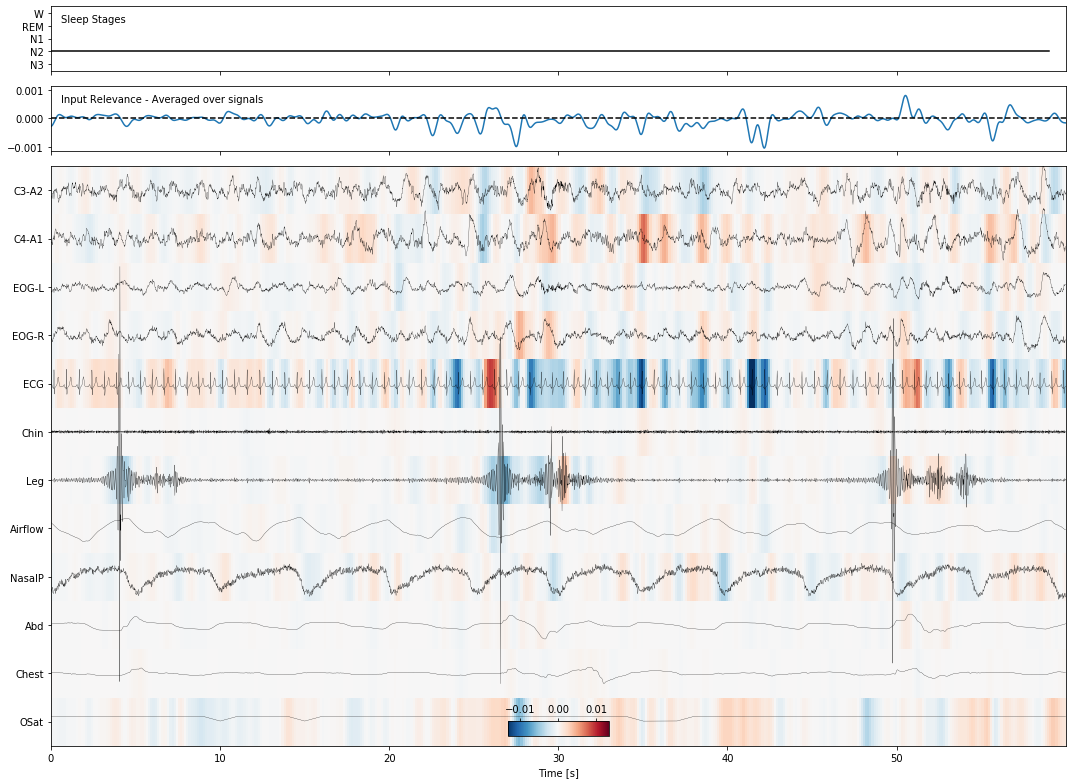

In [564]:
# EEG, EEG+EOG+EMG
#start_idx = 5*60*60 + 300*(8)
#dur = 90
# full
start_idx = 5*60*60 + 300*(10) + 150
dur = 60
# ECG
#start_idx = 5*60*60 + 300*(2) + 210
#dur = 60
# resp
#start_idx = 5*60*60 + 300*(-6)
#dur = 300
#start_idx = 5*60*60 + 300*(2) + 240
#start_idx = 5*60*60 + 300*(-11)
#start_idx = 5*60*60 + 300*(3) + 200
#dur = 300
fig = plot_psg_alpha(psg, fs, offset_channel, channel_names, channel_scale, channel_bias, ssc_p, interp, t_lim = [start_idx, start_idx + dur], HR=HR)
plt.show()

In [270]:
t_lim = [start_idx, start_idx + dur]
print('Chronological Age: {:.1f}, Age Estimate: {:.1f}.'.format(predictions[record]['label'][0], predictions[record]['age_p'][0]))
print('Prediction 5-min: {:.2f}'.format(preictions_pre[record]['age_p'][(start_idx)//(5*60)]))
print('Interpretation sum: {:.2f}'.format(np.sum(np.sum(interp,0)[t_lim[0]*128:t_lim[1]*128])))
print('Delta sum: {:.2f}'.format(delta[(start_idx)//(5*60)]))

Chronological Age: 72.7, Age Estimate: 58.9.
Prediction 5-min: 60.93
Interpretation sum: 8.66
Delta sum: -1.51


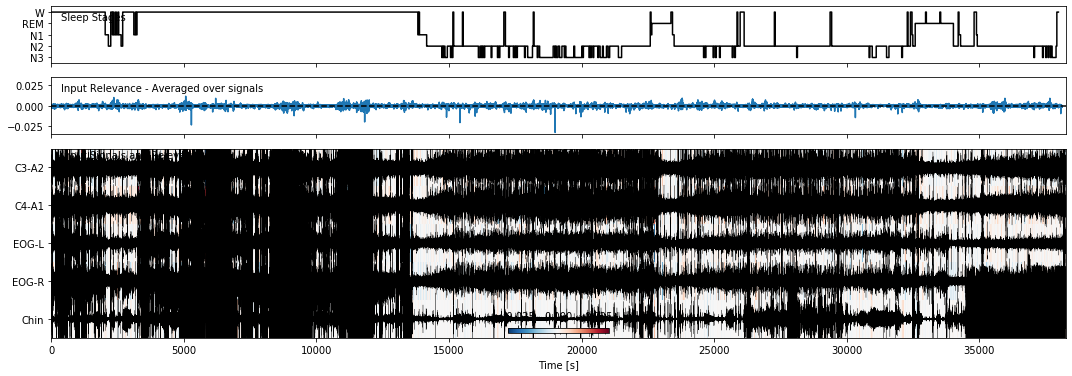

In [74]:
fig = plot_psg_alpha(psg, fs, offset_channel, channel_names, channel_scale, channel_bias, ssc_p, interp)
plt.show()

In [201]:
# How important is each signal:
# Global:
print('Sum of signal relevance: {:.3f}'.format(np.sum(np.array(interp)) / (interp.shape[1] / config.epoch_size)))
print('Signal abs relevance: ',np.sum(np.abs(np.array(interp)),1) / np.sum(np.abs(np.array(interp))))
print('Signal relevance: ',np.sum((np.array(interp)),1) / np.sum((np.array(interp))))
# TODO: only compare alpha and relevance over sleep stages in mixed epochs (find requirement for mixed epochs)
# How does alpha-full relate to ssc
print('Wake average alpha: {:.3g}.'.format(np.mean([abs(x) for i, x in enumerate(alpha_full[:int(len(ssc_p)/2.5)]) if ssc_p[int(np.ceil(i*2.5))] == 1])))
print('REM average alpha: {:.3g}.'.format(np.mean([abs(x) for i, x in enumerate(alpha_full[:int(len(ssc_p)/2.5)]) if ssc_p[int(np.ceil(i*2.5))] == 0])))
print('N2 average alpha: {:.3g}.'.format(np.mean([abs(x) for i, x in enumerate(alpha_full[:int(len(ssc_p)/2.5)]) if ssc_p[int(np.ceil(i*2.5))] == -1])))
print('N2 average alpha: {:.3g}.'.format(np.mean([abs(x) for i, x in enumerate(alpha_full[:int(len(ssc_p)/2.5)]) if ssc_p[int(np.ceil(i*2.5))] == -2])))
print('N3 average alpha: {:.3g}.'.format(np.mean([abs(x) for i, x in enumerate(alpha_full[:int(len(ssc_p)/2.5)]) if ssc_p[int(np.ceil(i*2.5))] == -3])))
# How does alpha-top relate to ssc
print('Wake average alpha: {:.3g}.'.format(np.mean([abs(alpha[0][int(np.floor(i / (5*60)))]) for i, s in enumerate(ssc_p[:alpha.shape[1]*5*60]) if s == 1])))
print('REM average alpha: {:.3g}.'.format(np.mean([abs(alpha[0][int(np.floor(i / (5*60)))]) for i, s in enumerate(ssc_p[:alpha.shape[1]*5*60]) if s == 0])))
print('N1 average alpha: {:.3g}.'.format(np.mean([abs(alpha[0][int(np.floor(i / (5*60)))]) for i, s in enumerate(ssc_p[:alpha.shape[1]*5*60]) if s == -1])))
print('N2 average alpha: {:.3g}.'.format(np.mean([abs(alpha[0][int(np.floor(i / (5*60)))]) for i, s in enumerate(ssc_p[:alpha.shape[1]*5*60]) if s == -2])))
print('N3 average alpha: {:.3g}.'.format(np.mean([abs(alpha[0][int(np.floor(i / (5*60)))]) for i, s in enumerate(ssc_p[:alpha.shape[1]*5*60]) if s == -3])))
# print('Wake average alpha',np.mean([abs(x) if np.repeat(np.array(ssc_p[0::30]), 30/2.5)[i] == 1 else 0 for i, x in enumerate(alpha_full[:len(ssc_p*2.5//30)])]))
# print('REM average alpha',np.mean([abs(x) if np.repeat(np.array(ssc_p[0::30]), 30/2.5)[i] == 0 else 0 for i, x in enumerate(alpha_full)]))
# print('NREM 1 average alpha',np.mean([abs(x) if np.repeat(np.array(ssc_p[0::30]), 30/2.5)[i] == -1 else 0 for i, x in enumerate(alpha_full)]))
# print('NREM 2 average alpha',np.mean([abs(x) if np.repeat(np.array(ssc_p[0::30]), 30/2.5)[i] == -2 else 0 for i, x in enumerate(alpha_full)]))
# print('NREM 3 average alpha',np.mean([abs(x) if np.repeat(np.array(ssc_p[0::30]), 30/2.5)[i] == -3 else 0 for i, x in enumerate(alpha_full)]))
# # How does relevance relate to ssc
# print('Wake average relevance',np.mean([(x) if np.array(ssc_p)[i] == 1 else 0 for i, x in enumerate(sum(pooling((interp),(config.n_channels,128),method='mean'),0)[:len(ssc_p)])]))
# print('REM average relevance',np.mean([(x) if np.array(ssc_p)[i] == 0 else 0 for i, x in enumerate(sum(pooling((interp),(config.n_channels,128),method='mean'),0)[:len(ssc_p)])]))
# print('NREM 1 average relevance',np.mean([(x) if np.array(ssc_p)[i] == -1 else 0 for i, x in enumerate(sum(pooling((interp),(config.n_channels,128),method='mean'),0)[:len(ssc_p)])]))
# print('NREM 2 average relevance',np.mean([(x) if np.array(ssc_p)[i] == -2 else 0 for i, x in enumerate(sum(pooling((interp),(config.n_channels,128),method='mean'),0)[:len(ssc_p)])]))
# print('NREM 3 average relevance',np.mean([(x) if np.array(ssc_p)[i] == -3 else 0 for i, x in enumerate(sum(pooling((interp),(config.n_channels,128),method='mean'),0)[:len(ssc_p)])]))


Sum of signal relevance: 21.976
Signal abs relevance:  [0.21532732 0.24542959 0.21429634 0.25349268 0.07145244]
Signal relevance:  [ 0.19299929  1.564709   -0.1702567  -0.5740015  -0.01345096]
Wake average alpha: 1.79e-05.
REM average alpha: 3.08e-05.
N2 average alpha: 3.45e-05.
N2 average alpha: 0.000112.
N3 average alpha: 0.000123.
Wake average alpha: 0.00216.
REM average alpha: 0.00358.
N1 average alpha: 0.00377.
N2 average alpha: 0.0132.
N3 average alpha: 0.016.
